In [1]:
#import packages
import pandas as pd
pd.set_option("display.max_columns", 100)
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#read in csv & display
wego = pd.read_csv('../data/headway_data_clean.csv')
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,0,0,0
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,0,0,0
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,0,0,0
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,0,0,0
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000,0,0,0
350324,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,MCC5_9,3.0,2,36.167091,-86.781923,2023-09-30 22:38:00,2023-09-30 22:49:18,2023-09-30 22:49:18,-11.300000,NaN,NaN,NaN,0,1,0,0,NaN,0,551,0.000000,0,0,0
350325,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 22:45:00,2023-09-30 22:49:19,2023-09-30 22:49:19,-4.316666,30.0,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000,0,0,0
350326,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 22:59:00,2023-09-30 23:21:05,2023-09-30 23:21:05,-22.083333,30.0,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000,0,0,0


In [3]:
#convert datetimes to datetime64
wego['DATE'] = pd.to_datetime(wego['DATE'], format = "%Y-%m-%d")
wego['SCHEDULED_TIME'] = pd.to_datetime(wego['SCHEDULED_TIME'], format = '%Y-%m-%d %H:%M:%S')
wego['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(wego['ACTUAL_ARRIVAL_TIME'], format = '%Y-%m-%d %H:%M:%S')
wego['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(wego['ACTUAL_DEPARTURE_TIME'], format = '%Y-%m-%d %H:%M:%S')
wego[['SCHEDULED_TIME', 'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SCHEDULED_TIME         350328 non-null  datetime64[ns]
 1   ACTUAL_ARRIVAL_TIME    338869 non-null  datetime64[ns]
 2   ACTUAL_DEPARTURE_TIME  338860 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.0 MB


In [4]:
#how many layovers = 0? 243,857(69.6%)

wego['DWELL_IN_MINS'].value_counts()

0.000000     243857
1.666666        719
1.716666        676
1.683333        648
1.700000        643
              ...  
45.450000         1
59.016666         1
42.933333         1
45.383333         1
0.133333          1
Name: DWELL_IN_MINS, Length: 3036, dtype: int64

In [5]:
#create df of value counts, plot on histogram

layovers = wego['DWELL_IN_MINS'].value_counts().sort_index().reset_index()
layovers

,index,DWELL_IN_MINS
0,-208.033333,1
1,-12.766666,1
2,-4.116666,1
3,-3.983333,1
4,-2.183333,1
...,...,...
3031,513.333333,1
3032,515.800000,1
3033,595.666666,1
3034,686.800000,1


<Axes: title={'center': 'Layover Length'}, ylabel='Frequency'>

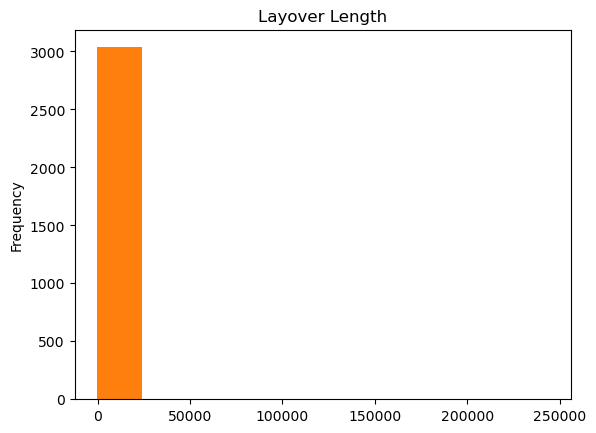

In [78]:
layovers.plot.hist(bins = 10, legend = False, title = 'Layover Length')

<Axes: ylabel='Frequency'>

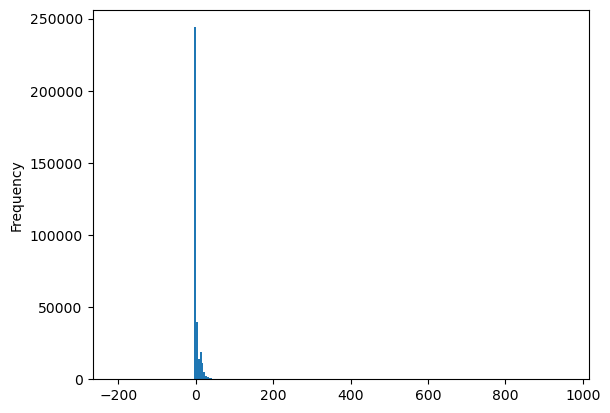

In [7]:
#plot dwell time
wego['DWELL_IN_MINS'].plot.hist(bins = 250)

In [10]:
#groupby route
wego.groupby(by = 'ROUTE_ABBR')

In [11]:
# create shifted headway deviation column to compare headway deviation delta between trips

wego['HDWY_DEV_SHIFT'] = wego['HDWY_DEV'].shift(1)
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,HDWY_DEV_SHIFT
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,0,0,0,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,0,0,0,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,0,0,0,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,0,0,0,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000,0,0,0,4.916666
350324,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,MCC5_9,3.0,2,36.167091,-86.781923,2023-09-30 22:38:00,2023-09-30 22:49:18,2023-09-30 22:49:18,-11.300000,NaN,NaN,NaN,0,1,0,0,NaN,0,551,0.000000,0,0,0,5.266666
350325,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 22:45:00,2023-09-30 22:49:19,2023-09-30 22:49:19,-4.316666,30.0,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000,0,0,0,NaN
350326,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 22:59:00,2023-09-30 23:21:05,2023-09-30 23:21:05,-22.083333,30.0,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000,0,0,0,1.866666


In [66]:
#CREATE HEADWAY DELTA in OG dataset to fix null values in firststop issue(failed)

wego['HDWY_DEV_DELTA'] = wego['HDWY_DEV_SHIFT'] - wego['HDWY_DEV']
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,HDWY_DEV_SHIFT,HDWY_DEV_DELTA
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,0,0,0,NaN,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,0,0,0,NaN,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,0,0,0,NaN,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,0,0,0,NaN,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000,0,0,0,4.916666,-0.350000
350324,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,MCC5_9,3.0,2,36.167091,-86.781923,2023-09-30 22:38:00,2023-09-30 22:49:18,2023-09-30 22:49:18,-11.300000,NaN,NaN,NaN,0,1,0,0,NaN,0,551,0.000000,0,0,0,5.266666,NaN
350325,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 22:45:00,2023-09-30 22:49:19,2023-09-30 22:49:19,-4.316666,30.0,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000,0,0,0,NaN,NaN
350326,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 22:59:00,2023-09-30 23:21:05,2023-09-30 23:21:05,-22.083333,30.0,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000,0,0,0,1.866666,-15.633334


In [70]:
# create df without trips where dwell time exceeds one hour,
# in hopes of removing incidents that do not represent a normal stop
layovers_no_outliers = wego.loc[(wego['DWELL_IN_MINS'] < 60) & (wego['DWELL_IN_MINS'] >= 0)]
layovers_no_outliers

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,HDWY_DEV_SHIFT,HDWY_DEV_DELTA
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,0,0,0,NaN,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,0,0,0,NaN,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,0,0,0,NaN,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,0,0,0,NaN,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000,0,0,0,4.916666,-0.350000
350324,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,MCC5_9,3.0,2,36.167091,-86.781923,2023-09-30 22:38:00,2023-09-30 22:49:18,2023-09-30 22:49:18,-11.300000,NaN,NaN,NaN,0,1,0,0,NaN,0,551,0.000000,0,0,0,5.266666,NaN
350325,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 22:45:00,2023-09-30 22:49:19,2023-09-30 22:49:19,-4.316666,30.0,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000,0,0,0,NaN,NaN
350326,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 22:59:00,2023-09-30 23:21:05,2023-09-30 23:21:05,-22.083333,30.0,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000,0,0,0,1.866666,-15.633334


<Axes: title={'center': 'Layover Length'}, ylabel='Frequency'>

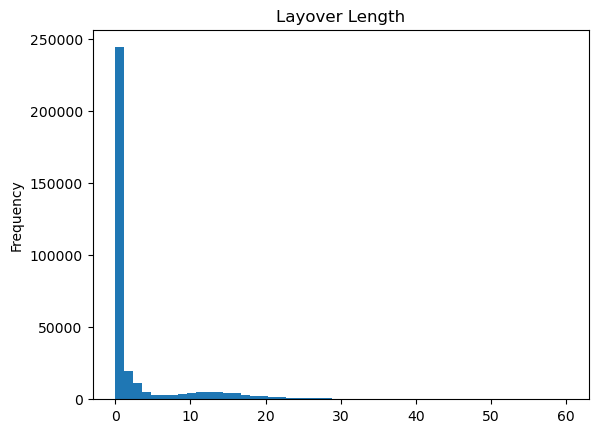

In [75]:
# plot dwell times without outliers

layovers_no_outliers['DWELL_IN_MINS'].plot.hist(bins = 50, title = 'Layover Length')

In [76]:
#average layover

layovers_no_outliers['DWELL_IN_MINS'].mean()

2.931221339603204

In [14]:
#linear regression of dwell times impact on headway deviation without outliers

lm = smf.ols('HDWY_DEV ~ DWELL_IN_MINS', data = layovers_no_outliers).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     28.00
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           1.22e-07
Time:                        13:10:46   Log-Likelihood:            -8.9883e+05
No. Observations:              265815   AIC:                         1.798e+06
Df Residuals:                  265813   BIC:                         1.798e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4791      0.015     30.923      0.000       0.449       0.509
DWELL_IN_MINS     0.0104      0.002      5.291      0.000       0.007       0.014
==============================================================================
Omnibus:                   512870.493   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       7718417691.192
Skew:                          14.361   Prob(JB):                         0.00
Kurtosis:                     837.301   Cond. No.                         8.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#cut down to 30 min window

q2_df = wego[(wego['DWELL_IN_MINS'] >= 0) & (wego['DWELL_IN_MINS'] < 30)]
q2_df



,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,HDWY_DEV_SHIFT
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,0,0,0,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,0,0,0,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,0,0,0,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,0,0,0,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000,0,0,0,4.916666
350324,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,MCC5_9,3.0,2,36.167091,-86.781923,2023-09-30 22:38:00,2023-09-30 22:49:18,2023-09-30 22:49:18,-11.300000,NaN,NaN,NaN,0,1,0,0,NaN,0,551,0.000000,0,0,0,5.266666
350325,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 22:45:00,2023-09-30 22:49:19,2023-09-30 22:49:19,-4.316666,30.0,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000,0,0,0,NaN
350326,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 22:59:00,2023-09-30 23:21:05,2023-09-30 23:21:05,-22.083333,30.0,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000,0,0,0,1.866666


In [16]:
# how often is DWELL_IN_MIN 0 at the start of the trip?

atstart = (wego['DWELL_IN_MINS'] == 0) & (wego['TRIP_EDGE'] == 1)
atstart.sum()

4909

In [17]:
# what percentage of trips is that?
5/68

0.07352941176470588

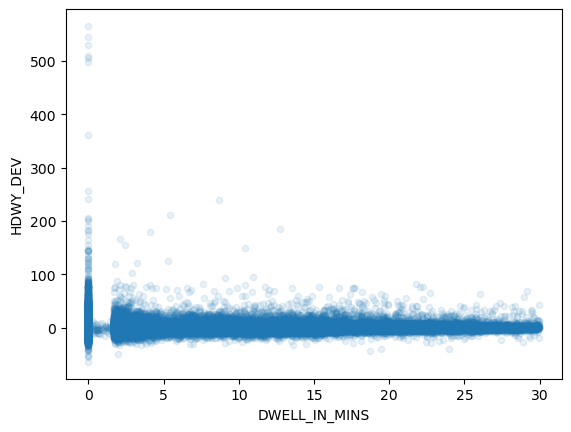

In [81]:
lm_plot = q2_df.plot(x = 'DWELL_IN_MINS', y = 'HDWY_DEV', kind = 'scatter', alpha = 0.1)

<Axes: title={'center': 'Impact of Layovers on Headway Deviation'}, xlabel='DWELL_IN_MINS', ylabel='Headway Deviation'>

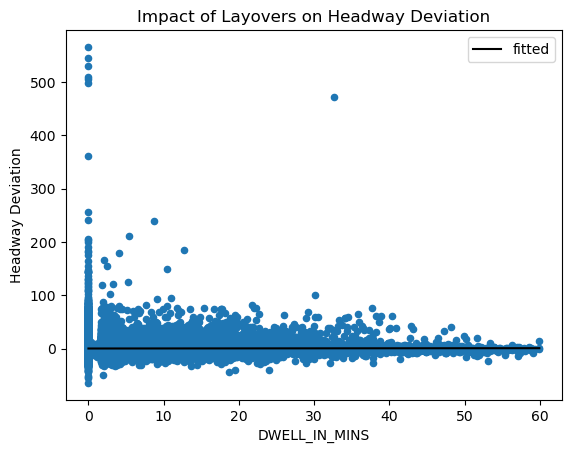

In [84]:
lm_plot = layovers_no_outliers.plot(x = 'DWELL_IN_MINS', y = 'HDWY_DEV', kind = 'scatter', alpha = 1, title = 'Impact of Layovers on Headway Deviation', xlabel = 'Layovers', ylabel = 'Headway Deviation')

fit_lm = pd.DataFrame({
    'DWELL_IN_MINS': np.linspace(
        start = layovers_no_outliers['DWELL_IN_MINS'].min(),
        stop = layovers_no_outliers['DWELL_IN_MINS'].max(), 
        num = 150)})
fit_lm['fitted'] = lm.predict(fit_lm)

fit_lm.plot(x = 'DWELL_IN_MINS', y = 'fitted', ax = lm_plot, color = 'black', label = 'fitted')

In [71]:
#trip edge zero ONLY
regstops = layovers_no_outliers.loc[(layovers_no_outliers['TRIP_EDGE'] == 0)]
regstops

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,HDWY_DEV_SHIFT,HDWY_DEV_DELTA
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.0,0,0,0,NaN,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.0,0,0,0,NaN,NaN
5,120230801,1,99457895,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,CV23,5.0,0,36.183480,-86.814220,2023-08-01 05:25:00,2023-08-01 05:24:03,2023-08-01 05:24:03,0.950000,NaN,NaN,NaN,0,0,1,0,0.0,0,51,0.0,0,0,0,NaN,NaN
8,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 05:46:00,2023-08-01 05:47:55,2023-08-01 05:47:55,-1.916666,35.0,36.966666,1.966666,0,0,1,0,0.0,0,70,0.0,0,0,0,2.666666,0.700000
9,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 05:54:00,2023-08-01 05:54:11,2023-08-01 05:54:11,-0.183333,15.0,14.516666,-0.483334,0,0,1,0,0.0,0,80,0.0,0,0,0,1.966666,2.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350311,120230930,2,100406598,2023-09-30,7,702,2312,353444,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 20:18:00,2023-09-30 20:24:13,2023-09-30 20:24:13,-6.216666,30.0,35.516666,5.516666,0,1,0,0,0.0,0,443,0.0,0,0,0,0.433333,-5.083333
350314,120230930,2,100406601,2023-09-30,7,702,2312,353445,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 20:59:00,2023-09-30 21:02:20,2023-09-30 21:02:20,-3.333333,28.0,30.316666,2.316666,0,0,1,0,0.0,0,467,0.0,0,0,0,1.200000,-1.116666
350317,120230930,2,100406604,2023-09-30,7,702,2312,353446,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 21:23:00,2023-09-30 21:30:00,2023-09-30 21:30:00,-7.000000,28.0,31.566666,3.566666,0,1,0,0,0.0,0,491,0.0,0,0,0,-1.933334,-5.500000
350323,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.0,0,0,0,4.916666,-0.350000


In [29]:
#linear check. still nothing. perhaps even more nothing than before

lm2 = smf.ols('HDWY_DEV ~ DWELL_IN_MINS', data = regstops).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     150.5
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           1.41e-34
Time:                        13:46:36   Log-Likelihood:            -6.9084e+05
No. Observations:              201803   AIC:                         1.382e+06
Df Residuals:                  201801   BIC:                         1.382e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4666      0.017     26.892      0.000       0.433       0.501
DWELL_IN_MINS     0.1375      0.011     12.267      0.000       0.115       0.159
==============================================================================
Omnibus:                   390458.707   Durbin-Watson:                   1.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5830982733.980
Skew:                          14.460   Prob(JB):                         0.00
Kurtosis:                     835.244   Cond. No.                         1.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='DWELL_IN_MINS', ylabel='HDWY_DEV'>

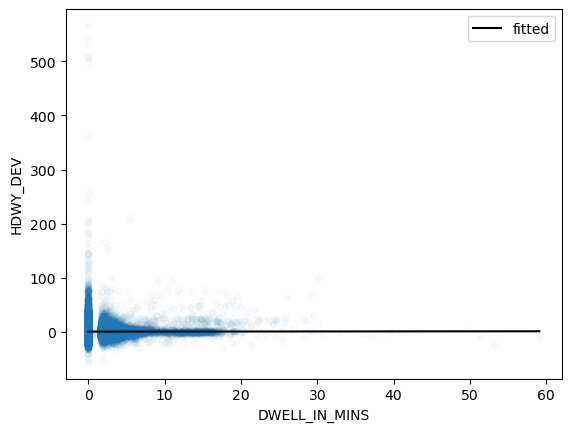

In [48]:
lm2_plot = regstops.plot(x = 'DWELL_IN_MINS', y = 'HDWY_DEV', kind = 'scatter', alpha = 0.025)

fit_lm2 = pd.DataFrame({
    'DWELL_IN_MINS': np.linspace(
        start = regstops['DWELL_IN_MINS'].min(),
        stop = regstops['DWELL_IN_MINS'].max(), 
        num = 150)})
fit_lm2['fitted'] = lm.predict(fit_lm2)

fit_lm2.plot(x = 'DWELL_IN_MINS', y = 'fitted', ax = lm2_plot, color = 'black', label = 'fitted')

In [28]:
regstops['HDWY_DEV_DELTA'] = regstops['HDWY_DEV_SHIFT'] - regstops['HDWY_DEV']
regstops

/var/folders/f_/3c498dtd4q9cs_ll7zmc_9hw0000gn/T/ipykernel_21351/3918455228.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regstops['HDWY_DEV_DELTA'] = regstops['HDWY_DEV_SHIFT'] - regstops['HDWY_DEV']


,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,HDWY_DEV_SHIFT,HDWY_DEV_DELTA
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.0,0,0,0,NaN,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.0,0,0,0,NaN,NaN
5,120230801,1,99457895,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,CV23,5.0,0,36.183480,-86.814220,2023-08-01 05:25:00,2023-08-01 05:24:03,2023-08-01 05:24:03,0.950000,NaN,NaN,NaN,0,0,1,0,0.0,0,51,0.0,0,0,0,NaN,NaN
8,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 05:46:00,2023-08-01 05:47:55,2023-08-01 05:47:55,-1.916666,35.0,36.966666,1.966666,0,0,1,0,0.0,0,70,0.0,0,0,0,2.666666,0.700000
9,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 05:54:00,2023-08-01 05:54:11,2023-08-01 05:54:11,-0.183333,15.0,14.516666,-0.483334,0,0,1,0,0.0,0,80,0.0,0,0,0,1.966666,2.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350311,120230930,2,100406598,2023-09-30,7,702,2312,353444,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 20:18:00,2023-09-30 20:24:13,2023-09-30 20:24:13,-6.216666,30.0,35.516666,5.516666,0,1,0,0,0.0,0,443,0.0,0,0,0,0.433333,-5.083333
350314,120230930,2,100406601,2023-09-30,7,702,2312,353445,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 20:59:00,2023-09-30 21:02:20,2023-09-30 21:02:20,-3.333333,28.0,30.316666,2.316666,0,0,1,0,0.0,0,467,0.0,0,0,0,1.200000,-1.116666
350317,120230930,2,100406604,2023-09-30,7,702,2312,353446,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 21:23:00,2023-09-30 21:30:00,2023-09-30 21:30:00,-7.000000,28.0,31.566666,3.566666,0,1,0,0,0.0,0,491,0.0,0,0,0,-1.933334,-5.500000
350323,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.0,0,0,0,4.916666,-0.350000


In [41]:
#linear regression plot of dwell time on headway(w/o outliers etc)

lm3 = smf.ols('HDWY_DEV_DELTA ~ DWELL_IN_MINS', data = regstops).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HDWY_DEV_DELTA   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     974.8
Date:                Sat, 11 Nov 2023   Prob (F-statistic):          1.76e-213
Time:                        14:11:07   Log-Likelihood:            -6.6006e+05
No. Observations:              197960   AIC:                         1.320e+06
Df Residuals:                  197958   BIC:                         1.320e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0456      0.016      2.818      0.005       0.014       0.077
DWELL_IN_MINS    -0.4162      0.013    -31.222      0.000      -0.442      -0.390
==============================================================================
Omnibus:                   284528.843   Durbin-Watson:                   2.241
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      27511641767.704
Skew:                          -6.839   Prob(JB):                         0.00
Kurtosis:                    1829.262   Cond. No.                         1.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: title={'center': 'Impact of Layover on Headway Deviation'}, xlabel='DWELL_IN_MINS', ylabel='Change in Headway Deviation'>

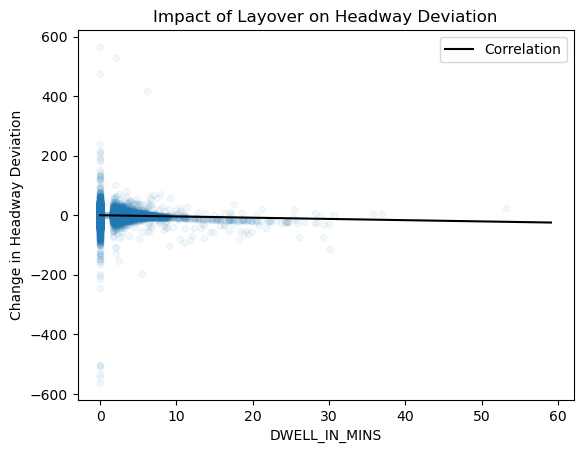

In [79]:
#linear regression plot of dwell time on headway(w/o outliers etc)

lm3_plot = regstops.plot(x = 'DWELL_IN_MINS', y = 'HDWY_DEV_DELTA', kind = 'scatter', alpha = 0.05, legend = False, title = 'Impact of Layover on Headway Deviation', xlabel= 'Layover', ylabel = 'Change in Headway Deviation')

fit_lm3 = pd.DataFrame({
    'DWELL_IN_MINS': np.linspace(
        start = regstops['DWELL_IN_MINS'].min(),
        stop = regstops['DWELL_IN_MINS'].max(), 
        num = 150)})
fit_lm3['fitted'] = lm3.predict(fit_lm3)

fit_lm3.plot(x = 'DWELL_IN_MINS', y = 'fitted', ax = lm3_plot, color = 'black', label = 'Correlation')

In [44]:
# logistic regression (failed)
lm3 = smf.ols('HDWY_DEV_DELTA ~ np.log(I(DWELL_IN_MINS))', data = regstops).fit()
lm3.summary()

/Users/mauriaparker/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mauriaparker/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


LinAlgError: SVD did not converge

<Axes: ylabel='Frequency'>

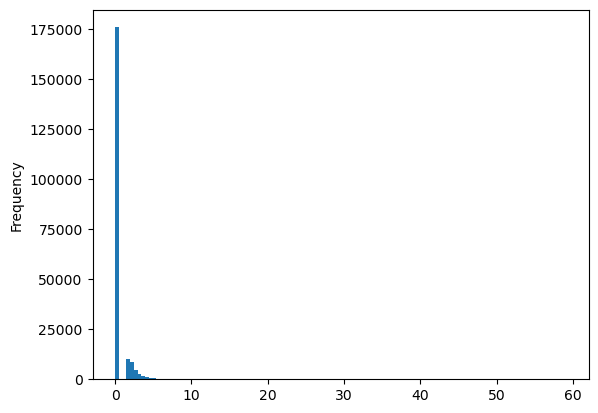

In [50]:
#layover distribution

regstops['DWELL_IN_MINS'].plot.hist(bins = 120)

In [49]:
regstops['DWELL_IN_MINS'].drop_duplicates().sort_values()

1          0.000000
88704      0.033333
128573     0.200000
127739     0.233333
210781     0.266666
            ...    
132447    39.566666
291053    49.316666
232217    51.300000
308863    53.166666
178801    59.100000
Name: DWELL_IN_MINS, Length: 997, dtype: float64

In [74]:
#trip edge one ONLY
firststop = layovers_no_outliers.loc[(layovers_no_outliers['TRIP_EDGE'] == 1)]
firststop

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,HDWY_DEV_SHIFT,HDWY_DEV_DELTA
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,0,0,0,NaN,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,0,0,0,NaN,NaN
7,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 05:42:00,2023-08-01 05:30:30,2023-08-01 05:43:43,-1.716666,35.0,37.666666,2.666666,0,0,1,0,0.0,0,63,13.216666,0,0,0,NaN,NaN
11,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 06:15:00,2023-08-01 06:05:31,2023-08-01 06:16:19,-1.316666,15.0,12.833333,-2.166667,0,0,1,0,0.0,0,97,10.800000,0,0,0,NaN,NaN
14,120230801,1,99457904,2023-08-01,22,2200,1040,345108,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 06:42:00,2023-08-01 06:30:59,2023-08-01 06:43:31,-1.516666,60.0,59.800000,-0.200000,0,0,1,0,0.0,0,124,12.533333,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350313,120230930,2,100406600,2023-09-30,7,702,2312,353445,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 20:45:00,2023-09-30 20:40:02,2023-09-30 20:48:17,-3.283333,30.0,31.200000,1.200000,0,0,1,0,0.0,0,456,8.250000,0,0,0,NaN,NaN
350316,120230930,2,100406603,2023-09-30,7,702,2312,353446,0,TO DOWNTOWN,HBHS,5.0,1,36.107575,-86.812719,2023-09-30 21:16:00,2023-09-30 21:12:40,2023-09-30 21:16:51,-0.850000,28.0,26.066666,-1.933334,0,0,1,0,0.0,0,482,4.183333,0,0,0,NaN,NaN
350319,120230930,2,100406606,2023-09-30,7,702,2312,353447,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 21:45:00,2023-09-30 21:43:52,2023-09-30 21:50:54,-5.900000,30.0,36.716666,6.716666,0,0,1,0,0.0,0,504,7.033333,0,0,0,NaN,NaN
350322,120230930,2,100406609,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,HBHS,5.0,1,36.107575,-86.812719,2023-09-30 22:16:00,2023-09-30 22:22:39,2023-09-30 22:24:37,-8.616666,30.0,34.916666,4.916666,0,1,0,0,0.0,0,530,1.966666,0,0,0,NaN,NaN


In [63]:
#are there even values in the column?
firststop['HDWY_DEV_SHIFT'].max()

nan

In [64]:
#isolate first stop (failed due to null columns. why are the columns null? i have no idea)

#i went back and changed the underlying dfs to try to fix it but it no work

lm4 = smf.ols('HDWY_DEV_DELTA ~ DWELL_IN_MINS', data = firststop).fit()
lm4.summary()

ValueError: zero-size array to reduction operation maximum which has no identity

NameError: name 'lm4' is not defined

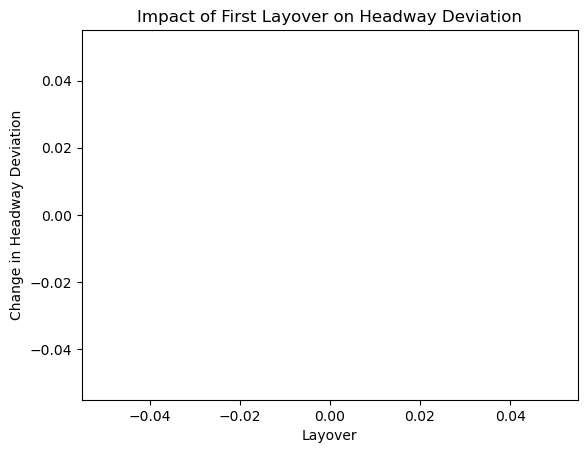

In [65]:
lm4_plot = firststop.plot(x = 'DWELL_IN_MINS', y = 'HDWY_DEV_DELTA', kind = 'scatter', alpha = 0.05, legend = False, title = 'Impact of First Layover on Headway Deviation', xlabel= 'Layover', ylabel = 'Change in Headway Deviation')

fit_lm4 = pd.DataFrame({
    'DWELL_IN_MINS': np.linspace(
        start = regstops['DWELL_IN_MINS'].min(),
        stop = regstops['DWELL_IN_MINS'].max(), 
        num = 150)})
fit_lm4['fitted'] = lm4.predict(fit_lm4)

fit_lm4.plot(x = 'DWELL_IN_MINS', y = 'fitted', ax = lm3_plot, color = 'black', label = 'Correlation')